In [1]:
import os.path
import pandas as pd
import pandas_datareader.data as web
import requests
from datetime import datetime
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
import pyfolio as pf


now = datetime.now()
start = datetime.strptime("01-04-2010", "%m-%d-%Y")
##base_url = 'http://ws.spk.gov.tr/PortfolioValues/api/PortfoyDegerleri/'

portfolio = pd.DataFrame({'Name': [],'Number': [],'Price': []})
backtrack = pd.DataFrame(index=pd.date_range(start, now, dtype='datetime64[ns]'), columns = ['MarketValue', 'Cost', 'ReturnSeries'])
backtrack = backtrack.fillna(0)
money = int(raw_input("Starting money:"))
monthly_money = int(raw_input("Montly investment:"))
#Stock code list and their percentages.
code_list = []
code_list_perc = []
number_of_inputs = int(raw_input("Number of stocks:"))


for i in range(0,number_of_inputs):
    #Stock name and percentages
    stock_name = str(raw_input("Name of the stock:"))
    stock_percentage = float(raw_input("Stock percentage:"))
    code_list.append(stock_name)
    code_list_perc.append(stock_percentage)
    #Getting the initial stock variables.
    ##resp = requests.get(base_url + stock_name + "/2/" + "01-02-2014/01-02-2014")
    resp = web.DataReader(stock_name, 'yahoo', start, start)['Adj Close']
    for item in resp.iteritems():
        number_of_stocks = (stock_percentage * money) / item[1]
        s = pd.Series([stock_name, number_of_stocks, item[1]], index = ['Name', 'Number', 'Price'])
    portfolio = portfolio.append(s, ignore_index=True)


Starting money:10000
Montly investment:0
Number of stocks:6
Name of the stock:VTI
Stock percentage:0.35
Name of the stock:VEA
Stock percentage:0.2
Name of the stock:VWO
Stock percentage:0.15
Name of the stock:VIG
Stock percentage:0.07
Name of the stock:XLE
Stock percentage:0.05
Name of the stock:MUB
Stock percentage:0.18


In [2]:

portfolio['Value'] = portfolio.Number * portfolio.Price
#Determining the initial backtrack positions.
backtrack.ix[start, 'MarketValue'] = portfolio['Value'].sum()
backtrack.ix[start, 'Cost'] = portfolio['Value'].sum()
start = start + timedelta(days=1)
i = 0
for stock in code_list:
    ##start_date = datetime.strftime(start, '%m-%d-%Y')
    ##end_date = datetime.strftime(now, '%m-%d-%Y')
    ##second_base_url = base_url + stock + "/2/" + start_date + "/" + end_date
    ##response = requests.get(second_base_url, timeout=None)
    response = web.DataReader(stock, 'yahoo', start, now)['Adj Close']
    #Calculating the money for certain stock.
    money_for_stock = money * code_list_perc[i]
    stock_month = 1
    for item in response.iteritems():
        date_string = str(item[0]).split(" ")[0]
        my_date = datetime.strptime(date_string, "%Y-%m-%d")
        portfolio.ix[i,'Price'] = item[1]
        backtrack.ix[my_date, 'MarketValue'] += portfolio.ix[i,'Number'] * portfolio.ix[i,'Price']
        backtrack.ix[my_date, 'Cost'] += money_for_stock
        back_date = my_date - timedelta(days=1)
        while (backtrack.ix[back_date, 'MarketValue'] == 0):
            back_date = back_date - timedelta(days=1)
        backtrack.ix[my_date, 'ReturnSeries'] = (backtrack.ix[my_date, 'MarketValue'] /
        (backtrack.ix[back_date, 'MarketValue'] +
        (backtrack.ix[my_date, 'Cost'] - backtrack.ix[back_date, 'Cost']))) - 1
        #Doing the montly investment.
        if (my_date.month != stock_month):
            money_for_stock += monthly_money * code_list_perc[i]
            stock_month += 1
            if stock_month == 13 : stock_month = 1
            portfolio.ix[i,'Number'] += (monthly_money * code_list_perc[i]) / item[1]
    #Increasing i for the next stocks percentage.
    i += 1




backtrack = backtrack[backtrack.MarketValue != 0]
plt.plot(backtrack['ReturnSeries'])
plt.savefig('x.png')
new = backtrack['ReturnSeries']
new = new.tz_localize('utc')


In [3]:
portfolio

,Name,Number,Price,Value
0,VTI,70.090899,122.650002,3500.0
1,VEA,70.317618,38.410000,2000.0
2,VWO,42.092668,38.610001,1500.0
3,VIG,17.191001,91.160004,700.0
4,XLE,9.824704,72.120003,500.0
5,MUB,21.392337,108.190002,1800.0


In [4]:

new = backtrack['ReturnSeries']
plt.plot(new)
plt.savefig('x.png')

new.to_csv('atk.csv')
new = new.tz_localize('utc')

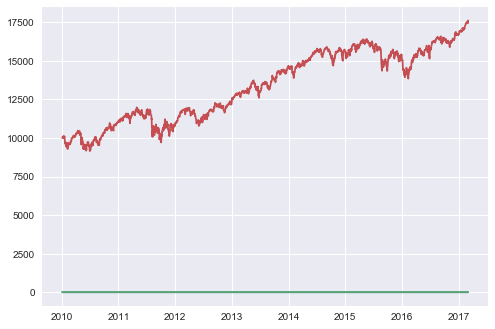

In [5]:
plt.plot(backtrack['MarketValue'])
plt.show()

Entire data start date: 2010-01-04
Entire data end date: 2017-03-02


Backtest Months: 85


Performance statistics,Backtest
annual_return,0.08
cum_returns_final,0.75
annual_volatility,0.14
sharpe_ratio,0.63
calmar_ratio,0.43
stability_of_timeseries,0.90
max_drawdown,-0.19
omega_ratio,1.12
sortino_ratio,0.89
skew,-0.40


Worst drawdown periods,net drawdown in %,peak date,valley date,recovery date,duration
0,19.00,2011-04-29,2011-10-03,2012-09-07,356
1,15.60,2015-05-21,2016-02-11,2016-08-09,319
2,12.45,2010-04-14,2010-07-02,2010-10-05,125
3,8.25,2013-05-21,2013-06-24,2013-09-16,85
4,8.18,2010-01-11,2010-02-08,2010-03-17,48




[-0.017 -0.034]


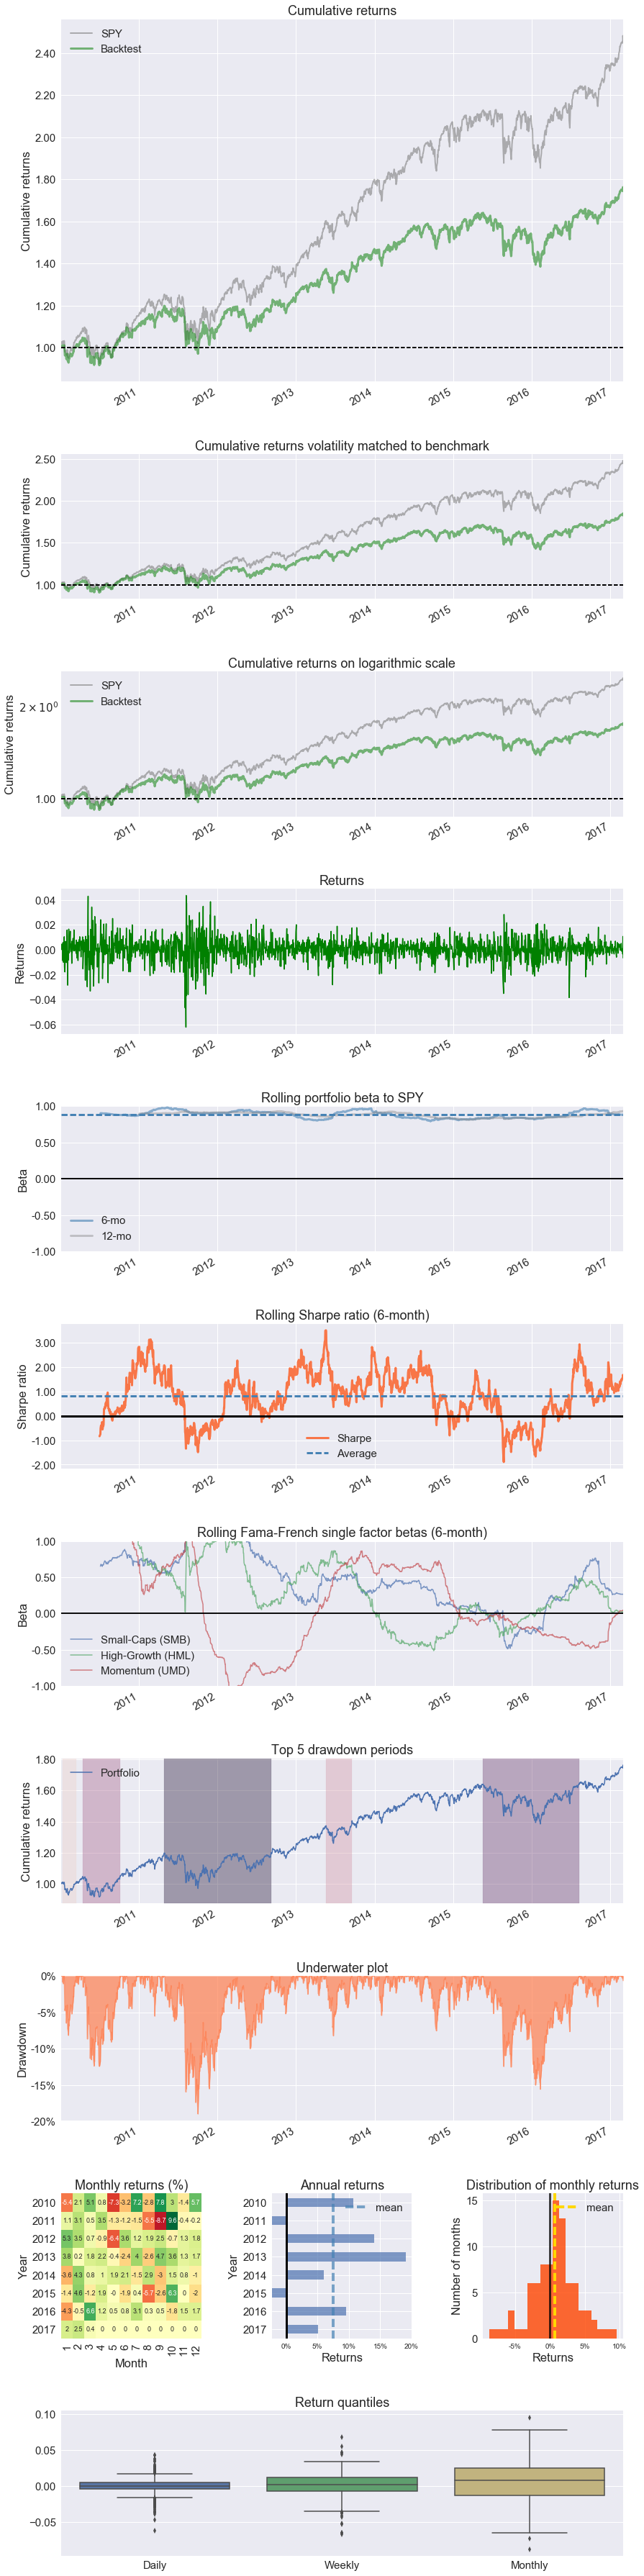

In [6]:
pf.create_returns_tear_sheet(new)

,Name,Number,Price
0,VTI,39.016026,89.706728
1,VEA,66.907322,37.365118
2,VWO,109.347192,36.580729
